# Multi-Qubit-Classifier - Classical Encoding



In [198]:
import tensorflow as tf
import tensorflow_quantum as tfq

from sklearn.metrics import accuracy_score,log_loss,confusion_matrix,classification_report
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

import seaborn as sns

import cirq
import sympy
import numpy as np
import pandas as pd

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from cirq.contrib.svg import SVGCircuit

In [157]:
n_layer=3
n_qubits=3

### Generating data

Generate data to be classified:
- Linear (`linear`)
- Circle (`circle`)
- Moons (`moons`)
- 4 Circles (`xor`)
- Finance (`finance`)

In [199]:
def generate_data(dataset="linear"):
    np.random.seed(seed=123)
    n = 900

    if dataset=="linear":
        data = np.random.rand(n, 2)

        labels=[]

        for p in range(0,n):
            if data[p,0] <= 0.5:
                label=[1,0]
            else:
                label=[0,1]
            labels.append(label)
        labels=np.array(labels)


        # plot the line y = x
        xs = np.linspace(0, 1, 100)
        ys = 0.5 * np.ones_like(xs)
        plt.plot(ys, xs, '--k')

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points in Unit Square", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()
        
        
    elif dataset=="circle":
        data = np.random.rand(n, 2)

        labels=[]

        for p in range(0,n):
            if (data[p,0]-0.5)**2 + (data[p,1]-0.5)**2 <= 0.1:
                label=[1,0]
            else:
                label=[0,1]
            labels.append(label)
        labels=np.array(labels)

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points in Unit Circle", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()    

    elif dataset=="circle_2":
        data, label = make_circles(noise=0.1, factor=0.3, random_state=1,n_samples=n)    

        labels=[]

        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[1,0]
            else:
                tmp=[0,1]
            labels.append(tmp)
        labels=np.array(labels)


        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()



    elif dataset=="moons":
        data = np.random.rand(n, 2)


        data,label = make_moons(n_samples=n,random_state=5,noise=0.04)

        labels=[]

        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[1,0]
            else:
                tmp=[0,1]
            labels.append(tmp)
        labels=np.array(labels)


        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

    # title and axis lables
        plt.title("Data Points", fontweight="bold", fontsize=16)

    # put on a grid and show the plot
        plt.grid()
        plt.show()

    elif dataset=="xor":
        #centers = np.array([[0,0],[0,1],[1,0],[1,1]])
        centers = np.array([[0.25,0.25],[0.75,0.25],[0.25,0.75],[0.75,0.75]])      
        label = np.array([0,1,1,0])
        data = np.array([]).reshape(-1,3)
        for center, label in zip(centers,label):
            points = np.random.normal(loc=center,scale=0.09,size=(n//4,2))
            points_labels = np.hstack((points,label*np.ones(n//4).reshape((-1, 1))))
            data = np.vstack((data,points_labels))
        erg=(data[:,[0,1]],data[:,2])
        data=erg[0]
        label=erg[1]

        labels=[]
        for j in range(0,len(label)):
            if label[j]==0:
                tmp=[0,1]
            else:
                tmp=[1,0]
            labels.append(tmp)
        labels=np.array(labels)

        for i in range(n):
            if labels[i,0] == 1:
                ckey = 'r'
            else:
                ckey = 'g'
            plt.scatter(data[i, 0], data[i, 1], color=ckey)

        # title and axis lables
        plt.title("Data Points XOR", fontweight="bold", fontsize=16)

        # put on a grid and show the plot
        plt.grid()
        plt.show()



    elif dataset=="finance":
        df=pd.read_csv('loans_norm.csv')
        df=df[['CreditCard','Zinssatz','Log_Einkommen','Schulden_zu_Einkommen','Fico-Score','Forderung','Ausfall']]
        df=np.array(df)

        data=df[0:n,:6]
        y=df[0:n,6]
        labels=[]
        for i in range(n):
            if y[i]==1:
                tmp=[1,0]
            else:
                tmp=[0,1]
            labels.append(tmp)
        labels=np.array(labels)      
    else:
        print("Data not implemented :-(")

    data_train,data_test,y_train,y_test= train_test_split(data,labels,stratify=labels,test_size=0.2,random_state=13)              
    return data_train, data_test, y_train, y_test

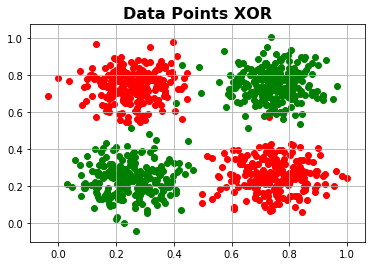

In [203]:
dta="xor"
data_train,data_test,y_train,y_test=generate_data(dataset=dta)

### Qubit Encoding


In [201]:
if data_train.shape[1] == 1:

    data_train = np.hstack((data_train,np.zeros(len(data_train)).reshape(-1,1),np.zeros(len(data_train)).reshape(-1,1)))
    data_test = np.hstack((data_test,np.zeros(len(data_test)).reshape(-1,1),np.zeros(len(data_test)).reshape(-1,1)))

if data_train.shape[1] == 2:

    data_train = np.hstack((data_train,np.zeros(len(data_train)).reshape(-1,1)))
    data_test = np.hstack((data_test,np.zeros(len(data_test)).reshape(-1,1)))

if data_train.shape[1] == 4:

    data_train = np.hstack((data_train,np.zeros(len(data_train)).reshape(-1,1),np.zeros(len(data_train)).reshape(-1,1)))
    data_test = np.hstack((data_test,np.zeros(len(data_test)).reshape(-1,1),np.zeros(len(data_test)).reshape(-1,1)))

if data_train.shape[1] == 5:

    data_train = np.hstack((data_train,np.zeros(len(data_train)).reshape(-1,1)))
    data_test = np.hstack((data_test,np.zeros(len(data_test)).reshape(-1,1)))

if data_train.shape[1] > 6:
  raise ValueError("please create a dataset whose number of features are divisible by 3 as there is no checking mechanisim implemented for values bigger than 6")



After defining the data, the input circuit is defined:

### Different encoding schemes:

In [161]:
## ZZ-Encoding
## n_qubits=3
## 6 Features 

def to_q_data(qdata,n_qubits):
    q_data=[]

    for p in range(0,len(qdata)):     
        if qdata.shape[1]==6:
            q_data.append(cirq.Circuit(
            cirq.H(qubits[0]),
            cirq.rz(2*qdata[p,0])(qubits[0]), 
            cirq.H(qubits[1]),
            cirq.rz(2*qdata[p,1])(qubits[1]),
            cirq.H(qubits[2]),
            cirq.rz(2*qdata[p,2])(qubits[2]),      
            
            cirq.CX(qubits[0],qubits[1]),
            cirq.rz(2*((np.pi-qdata[p,1])-(np.pi-qdata[p,0])))(qubits[1]),
            cirq.CX(qubits[0],qubits[1]),
            cirq.CX(qubits[1],qubits[2]),
            cirq.rz(2*((np.pi-qdata[p,2])-(np.pi-qdata[p,1])))(qubits[2]),
            cirq.CX(qubits[1],qubits[2]),
            
            cirq.H(qubits[0]),
            cirq.rz(2*qdata[p,3])(qubits[0]), 
            cirq.H(qubits[1]),
            cirq.rz(2*qdata[p,4])(qubits[1]),
            cirq.H(qubits[2]),
            cirq.rz(2*qdata[p,5])(qubits[2]),      
            
            cirq.CX(qubits[0],qubits[1]),
            cirq.rz(2*((np.pi-qdata[p,4])-(np.pi-qdata[p,3])))(qubits[1]),
            cirq.CX(qubits[0],qubits[1]),
            cirq.CX(qubits[1],qubits[2]),
            cirq.rz(2*((np.pi-qdata[p,5])-(np.pi-qdata[p,4])))(qubits[2]),
            cirq.CX(qubits[1],qubits[2])            
            ))
                        
#        if qdata.shape[1]>6:
#            print("Not yet implemented :-( ")
    return q_data

In [162]:
qubits = [cirq.GridQubit(x, y) for x in range(1) for y in range(n_qubits)]

q_data_train=to_q_data(data_train,n_qubits)
q_data_test=to_q_data(data_test,n_qubits)


x_train=tfq.convert_to_tensor(q_data_train);
x_test=tfq.convert_to_tensor(q_data_test);

In [163]:
q_data_train

[(0, 0): ───H───Rz(0.637π)───@────────────────@───H───Rz(0.439π)────────────────────────@────────────────@─────────────────────────
                            │                │                                         │                │
(0, 1): ───H───Rz(0.454π)───X───Rz(0.182π)───X───@────────────────@───H───Rz(0.131π)───X───Rz(0.309π)───X───@─────────────────@───
                                                 │                │                                         │                 │
(0, 2): ───H───Rz(0.321π)────────────────────────X───Rz(0.133π)───X───H───Rz(0.139π)────────────────────────X───Rz(-0.008π)───X───,
 (0, 0): ───H───Rz(0)────────@─────────────────@───H───Rz(0.189π)────────────────────────@────────────────@────────────────────────
                            │                 │                                         │                │
(0, 1): ───H───Rz(0.328π)───X───Rz(-0.328π)───X───@────────────────@───H───Rz(0.114π)───X───Rz(0.075π)───X───@────────────────@───
 

In [164]:
x_train

<tf.Tensor: shape=(720,), dtype=string, numpy=
array([b'\n\x0e\n\x0ctfq_gate_set\x12\xc0\x11\x08\x01\x12\x8b\x02\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_0\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_1\nW\n\x04\n\x02HP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x00\x00\x80?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\x00\x1a\x05\x12\x030_2\x12\x8b\x02\nW\n\x04\n\x02ZP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\x00\x80?\x12\x13\n\x08exponent\x12\x07\n\x05\r\x83\xf9"?\x12\x17\n\x0cglobal_shift\x12\x07\n\x05\r\x00\x00\x00\xbf\x1a\x05\x12\x030_0\nW\n\x04\n\x02ZP\x12\x1a\n\x0fexponent_scalar\x12\x07\n\x05\r\x00\

In [165]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


This is the definition of the whole net
work:

In [166]:
params=3*n_layer
control_params = sympy.symbols('theta:{}(0:{})'.format(n_qubits,params))

q_model = cirq.Circuit()

for j in range(0,n_layer):
    for i in range(0,n_qubits):
        q_model.append(cirq.rz(control_params[3*i*n_layer+3*j])(qubits[i]))
        q_model.append(cirq.ry(control_params[3*i*n_layer+3*j+1])(qubits[i]))
        q_model.append(cirq.rz(control_params[3*i*n_layer+3*j+2])(qubits[i]))
    if n_qubits==2 and j!=n_layer-1:
        q_model.append(cirq.CX(qubits[0],qubits[1]))        
    if n_qubits==3 and j!=n_layer-1:
        q_model.append(cirq.CX(qubits[0],qubits[1]))
        q_model.append(cirq.CX(qubits[1],qubits[2]))


In [167]:
q_model

(0, 0): ───Rz(theta00)───Ry(theta01)───Rz(theta02)───@───Rz(theta03)───Ry(theta04)───Rz(theta05)─────────────────@───Rz(theta06)───Ry(theta07)───Rz(theta08)─────────────────
                                                     │                                                           │
(0, 1): ───Rz(theta10)───Ry(theta11)───Rz(theta12)───X───@─────────────Rz(theta13)───Ry(theta14)───Rz(theta15)───X───@─────────────Rz(theta16)───Ry(theta17)───Rz(theta18)───
                                                         │                                                           │
(0, 2): ───Rz(theta20)───Ry(theta21)───Rz(theta22)───────X─────────────Rz(theta23)───Ry(theta24)───Rz(theta25)───────X─────────────Rz(theta26)───Ry(theta27)───Rz(theta28)───

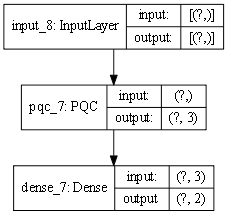

In [168]:

q_data_input = tf.keras.Input(
    shape=(), dtype=tf.dtypes.string)

if n_qubits==1:
    measurement = [cirq.Z(qubits[0])] 
if n_qubits==2:
    measurement = [cirq.Z(qubits[0]), cirq.Z(qubits[1])] 
if n_qubits==3:
    measurement = [cirq.Z(qubits[0]), cirq.Z(qubits[1]),cirq.Z(qubits[2])] 
if n_qubits==4:
    measurement = [cirq.Z(qubits[0]), cirq.Z(qubits[1]),cirq.Z(qubits[2]),cirq.Z(qubits[3])]     
    
    

expectation = tfq.layers.PQC(q_model,measurement)

expectation_output = expectation(q_data_input)

classifier = tf.keras.layers.Dense(2, activation=tf.keras.activations.softmax)
classifier_output = classifier(expectation_output)


model = tf.keras.Model(inputs=q_data_input, outputs=classifier_output)

# Standard compilation for classification
#model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
loss=tf.keras.losses.BinaryCrossentropy(),metrics=METRICS)
              
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)


In [169]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
pqc_7 (PQC)                  (None, 3)                 27        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 8         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________


In [170]:
history = model.fit(x=x_train, y=y_train, batch_size=32, epochs=20, verbose=1,validation_data=(x_test,y_test))                                    

Train on 720 samples, validate on 180 samples
Epoch 1/20
720/720 [==============================] - 10s 14ms/sample - loss: 0.6369 - tp: 468.0000 - fp: 252.0000 - tn: 468.0000 - fn: 252.0000 - accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - auc: 0.7158 - val_loss: 0.5190 - val_tp: 149.0000 - val_fp: 31.0000 - val_tn: 149.0000 - val_fn: 31.0000 - val_accuracy: 0.8278 - val_precision: 0.8278 - val_recall: 0.8278 - val_auc: 0.8269
Epoch 2/20
720/720 [==============================] - 8s 11ms/sample - loss: 0.4758 - tp: 598.0000 - fp: 122.0000 - tn: 598.0000 - fn: 122.0000 - accuracy: 0.8306 - precision: 0.8306 - recall: 0.8306 - auc: 0.8378 - val_loss: 0.4594 - val_tp: 150.0000 - val_fp: 30.0000 - val_tn: 150.0000 - val_fn: 30.0000 - val_accuracy: 0.8333 - val_precision: 0.8333 - val_recall: 0.8333 - val_auc: 0.8291
Epoch 3/20
720/720 [==============================] - 8s 11ms/sample - loss: 0.4443 - tp: 600.0000 - fp: 120.0000 - tn: 600.0000 - fn: 120.0000 - accuracy: 0.8333 - pr

## Results:

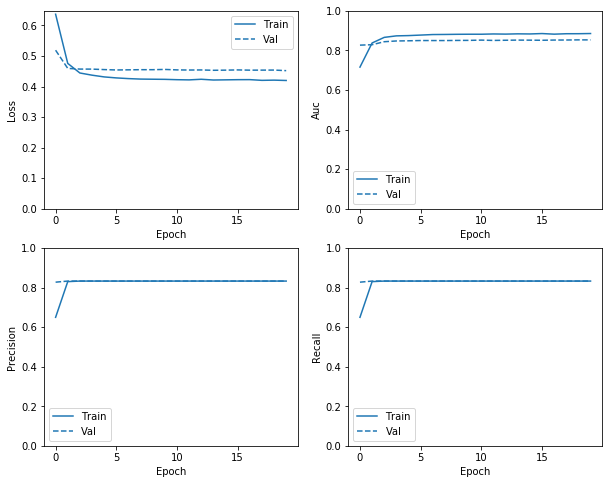

In [171]:
mpl.rcParams['figure.figsize'] = (10, 8)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    
plot_metrics(history)

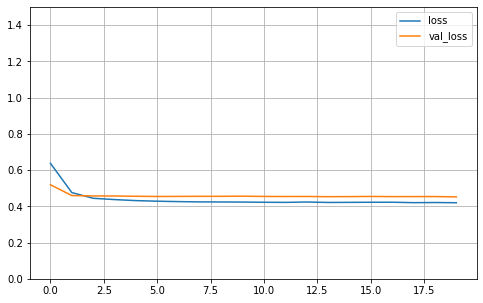

In [172]:
import pandas as pd
pd.DataFrame(history.history)[["loss","val_loss"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.0, 1.5) # set the vertical range to [0-1]
plt.show()

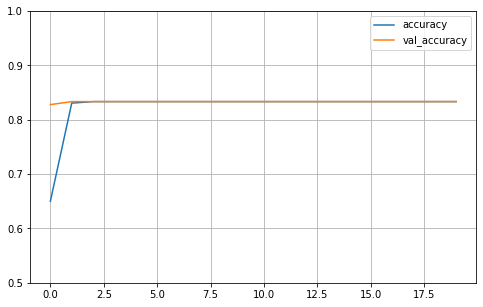

In [173]:
import pandas as pd
pd.DataFrame(history.history)[["accuracy","val_accuracy"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.5, 1) # set the vertical range to [0-1]
plt.show()

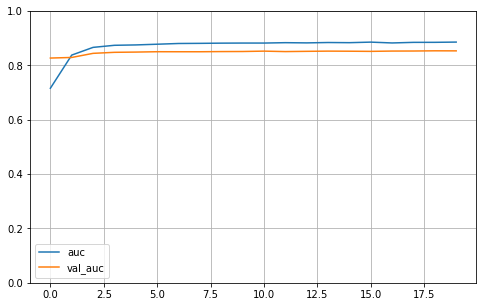

In [174]:
import pandas as pd
pd.DataFrame(history.history)[["auc","val_auc"]].plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0., 1) # set the vertical range to [0-1]
plt.show()

### Predictions

Calculate predictions on the whole dataset.



In [175]:
prob_train = model.predict(x_train, batch_size=32)
prob_test = model.predict(x_test, batch_size=32)

prob_tr=prob_train[:,0]
prob_te=prob_test[:,0]

y_tr=y_train[:,0]
y_te=y_test[:,0]


In [176]:
from scipy.optimize import minimize
def max_acc(x, a,b): 
    
    temp=[]
    for i in range(0,len(b)):
        if a[i]<x:
            temp.append(0)
        else:
            temp.append(1)
    return -accuracy_score(temp,b)

#obj=-max_acc(prob_tr_nn,y_tr,0.4)
out = minimize(fun=max_acc , x0=0.9, args=(prob_tr,y_tr), method="BFGS")
tr=out.x[0]
print(out)


      fun: -0.8333333333333334
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 3
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.9])


In [177]:
prog_tr=(prob_tr>tr)
prog_te=prob_te>tr

prog_train=prob_train>tr
prog_test=prob_test>tr

In [185]:
# compute statistics of the QNN
if dta != "finance":
    # plot the points, line y = x, and prediction
    #plt.plot(ys, xs, '--k')
    for i in range(len(prob_train)):
        if prog_tr[i] == 0:
            ckey = 'g'
        else:
            ckey = 'b'
        plt.scatter(data_train[i, 0], data_train[i, 1], color=ckey)
    plt.grid()
    plt.title("QNN Predictions", fontsize=16, fontweight="bold")
    plt.show()

In [184]:
# compute statistics of the QNN

if dta != "finance":
    # plot the points, line y = x, and prediction
    #plt.plot(ys, xs, '--k')
    for i in range(len(prob_test)):
        if prog_te[i] == 0:
            ckey = 'g'
        else:
            ckey = 'b'
        plt.scatter(data_test[i, 0], data_test[i, 1], color=ckey)
    plt.grid()
    plt.title("QNN Predictions", fontsize=16, fontweight="bold")
    plt.show()

In [186]:
def plot_decision_boundary(X, y, model, steps=1000, cmap='Paired'):
    """
    Function to plot the decision boundary and data points of a model.
    Data points are colored based on their actual label.
    """
    cmap = plt.get_cmap(cmap)

    # Define region of interest by data limits
    xmin, xmax = X[:,0].min() - 0.5, X[:,0].max() + 0.5
    ymin, ymax = X[:,1].min() - 0.5, X[:,1].max() + 0.5
    steps = 100
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    xxx=np.c_[xx.ravel(), yy.ravel(),np.zeros(len(x_span)*len(x_span)).reshape(-1,1)]
    xxx=to_q_data(xxx,n_qubits)
    xxx=tfq.convert_to_tensor(xxx)
    labels=0
    labels = model.predict(xxx)
 #   labels = model.predict(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    
    z = labels[:,0].reshape(xx.shape)

    z=z>tr
    
    fig, ax = plt.subplots()
    ax.contourf(xx, yy, z, cmap=cmap, alpha=0.5)

    # Get predicted labels on training data and plot
    train_labels = model.predict(tfq.convert_to_tensor(to_q_data(X,n_qubits)))
#    ax.scatter(X[:,0], X[:,1], c=np.array(y).ravel(), cmap=cmap, lw=0)
    ax.scatter(X[:,0], X[:,1], c=(np.array(train_labels[:,0]).ravel()>tr), cmap=cmap, lw=0)
    return fig, ax
if dta != "finance":
    plot_decision_boundary(data_test,y_te, model, cmap = 'RdBu')

In [187]:
print(accuracy_score(y_tr,prog_tr))
print(classification_report(y_train,prog_train))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.94      0.34      0.50       600

   micro avg       0.94      0.28      0.44       720
   macro avg       0.47      0.17      0.25       720
weighted avg       0.78      0.28      0.42       720
 samples avg       0.28      0.28      0.28       720



C:\Users\ghell\Anaconda3\envs\TFQuantum\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ghell\Anaconda3\envs\TFQuantum\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [189]:
results = model.evaluate(x_train, y_train,
                                  batch_size=20, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()


loss :  0.41777319833636284
tp :  600.0
fp :  120.0
tn :  600.0
fn :  120.0
accuracy :  0.8333333
precision :  0.8333333
recall :  0.8333333
auc :  0.8877121



True Negatives:  600
False Positives:  0
False Negatives:  120
True Positives):  0
Total Positives:  120


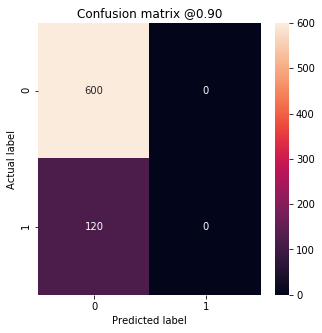

In [190]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives): ', cm[1][1])
  print('Total Positives: ', np.sum(cm[1]))

plot_cm(np.array(y_tr), np.array(prog_tr),tr)


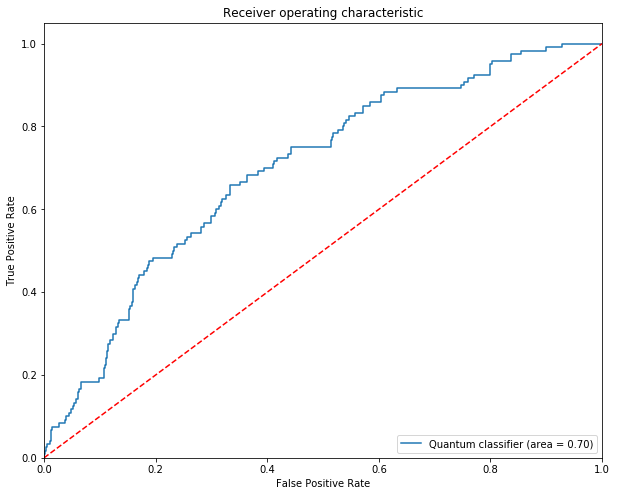

In [191]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_tr, prob_tr)
fpr, tpr, thresholds = roc_curve(y_tr, prob_tr)
plt.figure()
plt.plot(fpr, tpr, label='Quantum classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [192]:
results = model.evaluate(x_test, y_test,
                                  batch_size=32, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

len(x_test)

loss :  0.4520022922092014
tp :  150.0
fp :  30.0
tn :  150.0
fn :  30.0
accuracy :  0.8333333
precision :  0.8333333
recall :  0.8333333
auc :  0.85333335



180

In [194]:
print(accuracy_score(y_te,prog_te))
print(classification_report(y_te,prog_te))

0.8333333333333334
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       150
           1       0.00      0.00      0.00        30

    accuracy                           0.83       180
   macro avg       0.42      0.50      0.45       180
weighted avg       0.69      0.83      0.76       180



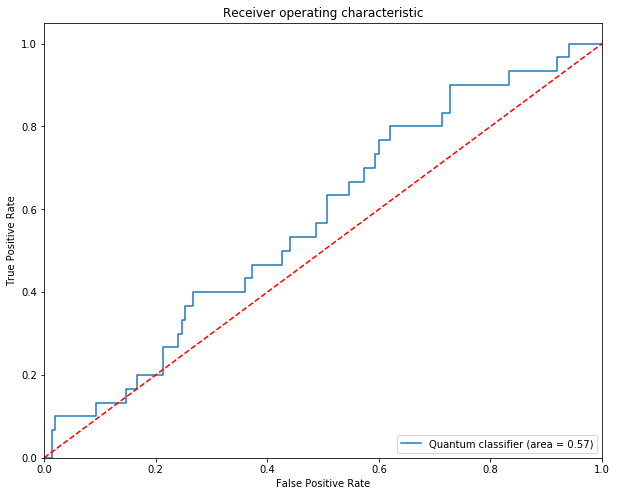

In [195]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_te, prob_te)
fpr, tpr, thresholds = roc_curve(y_te, prob_te)
plt.figure()
plt.plot(fpr, tpr, label='Quantum classifier (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

True Negatives:  150
False Positives:  0
False Negatives:  30
True Positives):  0
Total Positives:  30


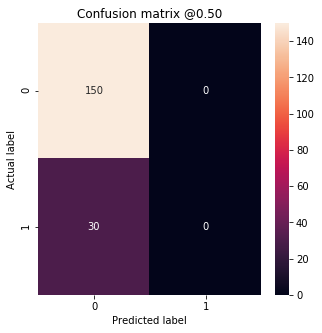

In [196]:
plot_cm(np.array(y_te), np.array(prog_te))

In [197]:
max(prob_tr)

0.4652055

### Traditionell Neural Net: